In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
import pandas as pd
import datetime
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas_profiling as pp
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from numpy import mean
from numpy import std
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost, CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

In [3]:
# обернем в класс все действия, связанные с предобработкой данных для лучшей воспроизводимости:
class Cust_preproc():
    def __init__(self, data=None, column=None):
        self.data = data
        self.column = column
    
    def fill_na(self, data, column):
        # функция заполнения пропусков модой
        data[column].fillna(data[column].mode()[0], inplace=True)
              
    def show_outliers(self, data, column): 
        # рассчет выбросов методом IQR, вывод нижней и верхней границы; подсчет записей, которые не входят в диапазон
        q25, q75 = data[column].quantile([0.25, 0.75])
        IQR = q75 - q25
        low_limit = q25 - 1.5 * IQR
        up_limit = q75 + 1.5 * IQR
        print("IQR range [{}, {}]".format(low_limit, up_limit), "\nMin. value: {} \nMax. value: {}".
          format(data[column].min(), data[column].max()))
        print("Number of entries below the lower limit: {}, number of entries above the upper limit: {}".
        format(data[data[column] < low_limit][column].count(), data[data[column] > up_limit][column].count())) 

def encode(data, option="w/dummy"):
# функция для преобразования признака Education в численный формат, кодирования бинарных переменных и создания dummy переменных из категориальных
    if option == 'wo/dummy':
    # опция без дамми переменных
        keys = data['education'].unique()
        values = range(1, data['education'].nunique()+1)
        edc_labels = dict(zip(keys, values))
        data['education'] = data['education'].map(edc_labels)
        
        label_encoder = LabelEncoder()   
        for col in bin_cols:
            data[col] = label_encoder.fit_transform(data[col])
               
    if option == 'w/dummy':
    # опция с дамми переменными
        keys = data['education'].unique()
        values = range(1, data['education'].nunique()+1)
        edc_labels = dict(zip(keys, values))
        data['education'] = data['education'].map(edc_labels)
        
        label_encoder = LabelEncoder()   
        for col in bin_cols:
            data[col] = label_encoder.fit_transform(data[col])
        
        data = pd.get_dummies(data, columns=cat_cols)
    return data
        
def bin_quant(data, x):
    # функция для разбивки значений по квартилям и превращения числового признака в категориальный
    q1, mean, q3 = data[x].quantile([0.25, 0.5, 0.75])   
    def split(y):
        if y <= q1:
            return 1
        if q1 < y <= mean:
            return 2
        if mean < y <= q3:
            return 3
        if y > q3:
            return 4       
    data["bin_"+x] = data[x].apply(lambda x: split(x)) # создание нового признака по квартилям
      
def neat_matrix(cf_matrix):
    # confusion matrix в подобающем виде 
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()

def print_metrics(y_v, y_p, y_proba):
    # рассчет f1 score, roc auc score и вывод confusion matrix определенной модели
    f1_val = f1_score(y_v, y_p)
    roc_auc = round(roc_auc_score(y_v, y_proba), 3)

    cf_matrix1 = confusion_matrix(y_v, y_p)
    
    fpr, tpr, threshold = roc_curve(y_v, y_proba)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    print('F1-score = {:.3f}'.format(f1_val))
    print('ROC AUC = {:.3f}'.format(roc_auc))
    neat_matrix(cf_matrix1)
    
    
def predict(data):
    # реализация логистической регрессии
    X = data[set(data.columns) - set(['default'])]
    y = data['default']
    
    # деление на тренировочную и валидационную выборку с учетом дисбаланса классов
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=30, stratify=y)
  
    # стандартизация тренировочной выборки и валидационной на основе параметров тренировочной
    scaler = StandardScaler().fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_valid_st = scaler.transform(X_valid)

    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_valid_st)
    y_pred_proba = model.predict_proba(X_valid_st)
    y_pred_proba = y_pred_proba[:,1]
    # оценка модели на основе f1 score, roc auc и confusion matrix
    return print_metrics(y_valid, y_pred, y_pred_proba)

def predict_model(data, model):
    # функция для оценки других моделей 
    X = data[set(data.columns) - set(['default'])]
    y = data['default']
    
    # деление на тренировочную и валидационную выборку с учетом дисбаланса классов
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=30, stratify=y)
  
    # стандартизация тренировочной выборки и валидационной на основе параметров тренировочной
    scaler = StandardScaler().fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_valid_st = scaler.transform(X_valid)

    # реализация модели на стандартных настройках и оценка на основе F1 и ROC AUC score
    m = model
    m.fit(X_train_st, y_train)
    y_pred = m.predict(X_valid_st)
    y_pred_proba = m.predict_proba(X_valid_st)
    y_pred_proba = y_pred_proba[:,1]
    f1 = f1_score(y_valid, y_pred)
    roc = roc_auc_score(y_valid, y_pred_proba)
    print(model, "\nF1_score: {:.3f}, ROC AUC score: {:.3f}\n".format(f1, roc))

# Information

In [4]:
path = '/kaggle/input/sf-dst-scoring/'

In [5]:
train = pd.read_csv(path +'/train.csv')
test = pd.read_csv(path +'test.csv')
sample = pd.read_csv(path +'/sample_submission.csv')

In [6]:
print(train.info())
print('Train size: ', train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

In [7]:
print(test.info())
print('Test size: ', train.shape)
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time foreign_passport  
0             2   50000    1           4                N  
1             2    5000    4           3                N  
2             2   30000    1           3                Y  
3             2   17000    1           3                N  
4             3  120000    1           3                N

In [8]:
print(sample.info())
print(sample.shape)
sample.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None
(24354, 2)


client_id   default
0      66799  0.441004
1      25379  0.138092
2      28825  0.373370
3      37530  0.476501
4       4264  0.304640

In [9]:
train['train'] = 1 # помечаем тренировочные
test['train'] = 0 # помечаем тестовые
df = pd.concat([train, test], ignore_index=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

#   **EDA**

## *Data Description:*
client_id - identification

education - education level

sex - sex

age - age

car - binary/ has a car or not

car_type - whether car is international

decline_app_cnt - declined application count in the past

good_work - binary/ has 'good' work or not

bki_request_cnt - requests to BKI

home_address - category of home address

work_address - category of work address

income - income

foreign_passport - binary/ has foreign passport

sna - connection with bank employee

first_time - age of information about the client

score_bki - BKI score

region_rating - region rating

app_date - application date

default - default flag

**Посмотрим на переменные и расспределения, воспользовавшись уже готовым репортом из pandas profiling**

In [10]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В датасете всего 18 переменных (помимо переменной train, разделяющая тренировочную и тестовую выборку) и целевая переменная default

Имеются признаки с различными типами данных - числовые, категориальные и бинарные. 

В целевой переменной default в тренировочной выборке отсутствуют пропуски, зато имеется существенный дисбаланс классов.

Пропуски присутствуют лишь в одной переменной - Education. Их к-во не существенно.

Из всех числовых переменных нормально распределена лишь score_bki. Все остальные имеют тяжелый левый хвост. 

app_date: данные представлены в виде даты. Это единственный признак, который должен быть значительно обработан для восприятия моделью. 

Region_rating: хоть данные и предоставлены в числовом виде, имеется некоторая тенденция к категориальности, где значения распределены от 20 до 80 с шагом в 10. 

Иcходя из контекста и описания, переменная car и car_type дублируют информацию друг друга. Возможно, эти две переменные будут иметь значительную коллинеарность (проверим позже)

Бинарные признаки будут обработаны с помощью LabelEncoder'a, а из категориальных признаков будут созданы dummy переменные.

In [11]:
# сгруппируем признаки по типам данных для последующего анализа
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'income', 'bki_request_cnt', 'region_rating'] 
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time'] 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] 

# Наивная модель

Посмотрим самую базовую модель с минимальной обработкой датасета. 
Для этого необходимо лишь заполнить пропуски, признак app_date мы пока удалим, обработаем бинарные признаки и создать дамми-переменные для категориальных

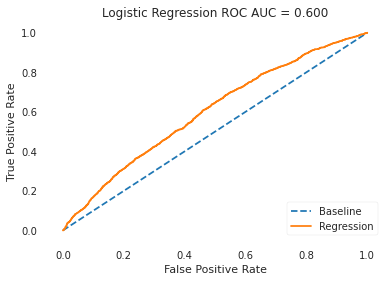

F1-score = 0.000
ROC AUC = 0.600


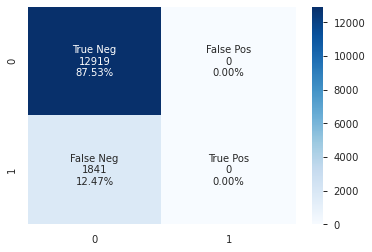

In [12]:
# Заполняем пропуски, преобразовываем признаки для обработки моделью 
preproc = Cust_preproc()
preproc.fill_na(df, 'education')

# скопируем датасет перед переобразованием
df_t = df.drop('app_date', axis=1) # убираем пока что необработанный признак app_date
df_t = encode(df_t, option='wo/dummy') # кодируем бинарные переменные для восприятия моделью

train = df_t.query('train == 1').drop(['train'], axis=1)

# строим базовую модель без нормализации признаков
X = train.drop('default', axis=1)
y = train['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:,1]

print_metrics(y_test, y_pred, y_pred_proba)

Очевидно, модель хорошо обучилась на преобладающем классе и определяет всех клиентов как не дефолтных, раздавая кредиты всем подряд. 
Продолжим дальше работать с датасетом, чтобы минимизировать процент на побочной диагонале матрицы (главным образом - FN) и улучшить ROC AUC

# Числовые признаки

Обработаем app_date в числовой признак: к-во дней с первой заявки в датасете и добавим его к числовым признакам для последующего анализа

In [13]:
# преобразуем в формат даты
df['app_date'] = pd.to_datetime(df['app_date'])

# вычислим к-во дней с самой давней записи в датасете 
df['app_days'] = df['app_date'].apply(lambda x: x - df['app_date'].min())
df['app_days'] = df['app_days'].dt.days
df.drop('app_date', axis=1, inplace=True)

# обновим список с числовыми признаками
num_cols = num_cols + ['app_days']

default
0.0    39.39
1.0    38.53
Name: age, dtype: float64
default
0.0    0.24
1.0    0.52
Name: decline_app_cnt, dtype: float64
default
0.0   -1.94
1.0   -1.68
Name: score_bki, dtype: float64
default
0.0    41799.71
1.0    36288.11
Name: income, dtype: float64
default
0.0    1.93
1.0    2.46
Name: bki_request_cnt, dtype: float64
default
0.0    57.17
1.0    53.68
Name: region_rating, dtype: float64


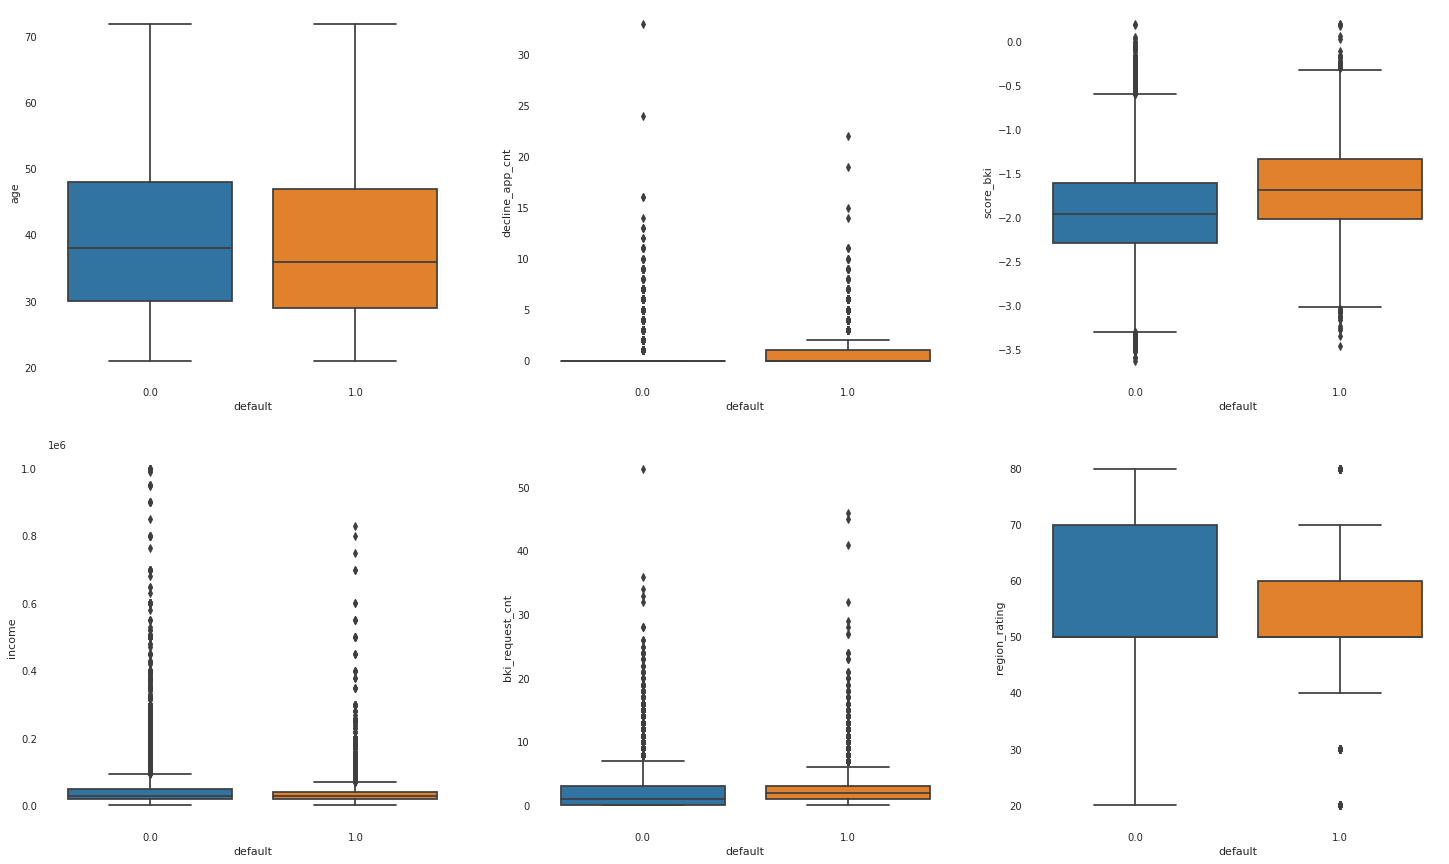

In [14]:
# расспределения дефолтных клиентов относительно числовых признаков (без app_days пока)
fig, axes = plt.subplots(2, 3, figsize=(25,15))
for i, col in enumerate(num_cols[:-1]):
    sns.boxplot(y = df[col], x = 'default', data=df, ax=axes.flat[i])
    print(round(df.groupby('default')[col].mean(),2))

1. Дефолтные клиенты в среднем моложе
2. БОльшее к-во отказанных заявок в прошлом
3. БОльший показатель BKI score
4. Меньший доход
5. БОльшее к-во запросов 
6. Меньшее значение по показателю region rating


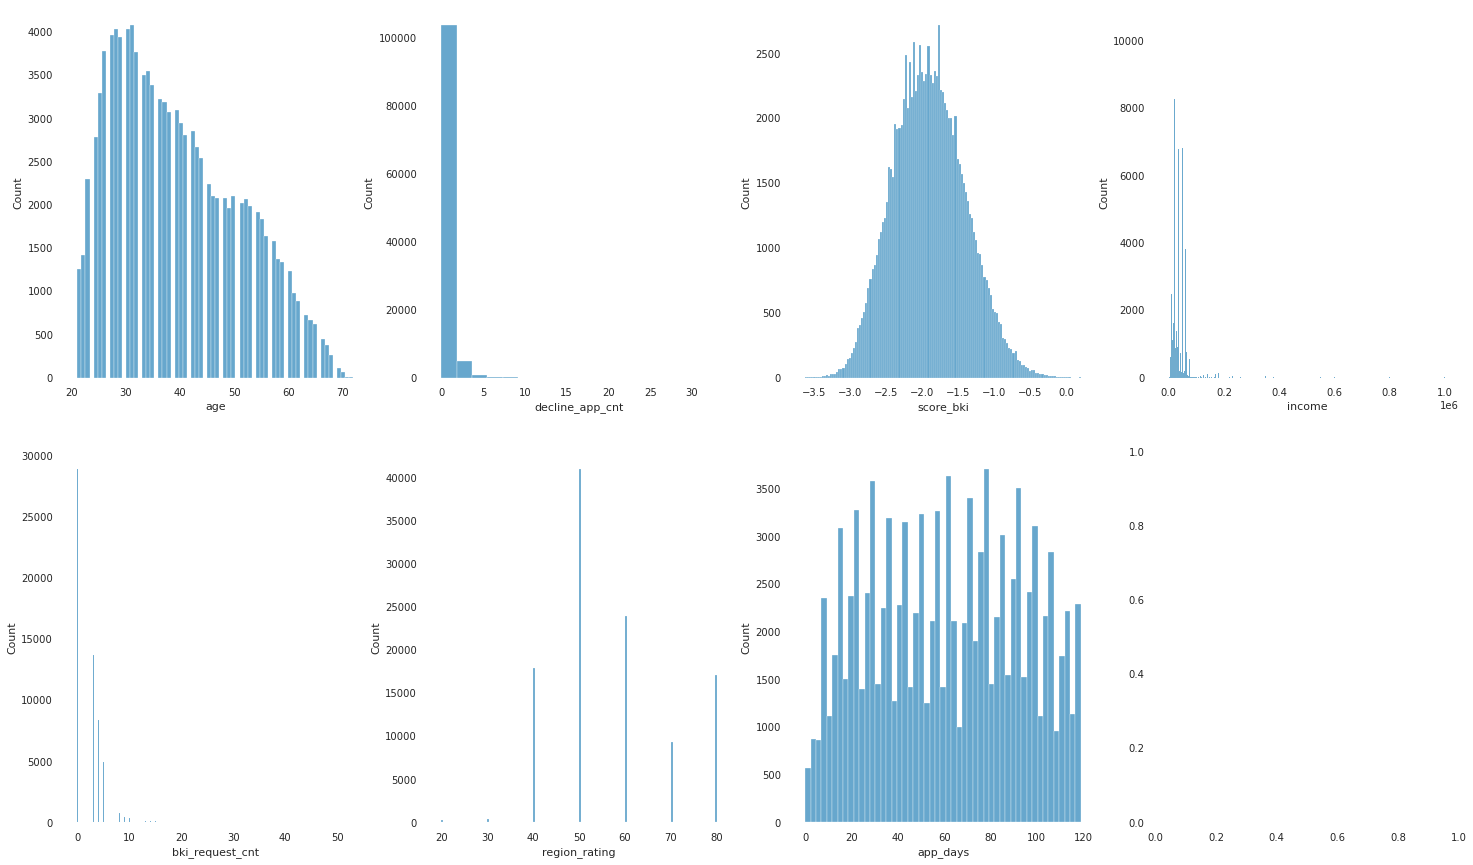

In [15]:
# отдельно еще раз сравним расспределения числовых переменных
fig, axes = plt.subplots(2, 4, figsize=(25,15))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes.flat[i])

Расспределения почти всех числовых переменных имеют тяжелый правый хвост. Примечательно, что score_bki расспределен нормально

<AxesSubplot:>

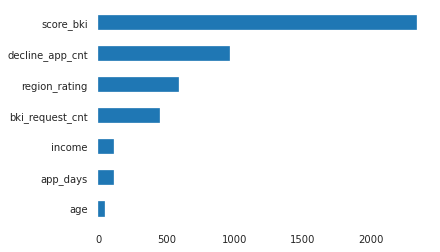

In [16]:
# значимость числовых переменных
train = df.query('train == 1').drop(['train'], axis=1)
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Категориальные и бинарные признаки

Смотрим на % распределение дефолтных и недефолтных клиентов по категориальным и бинарным признакам

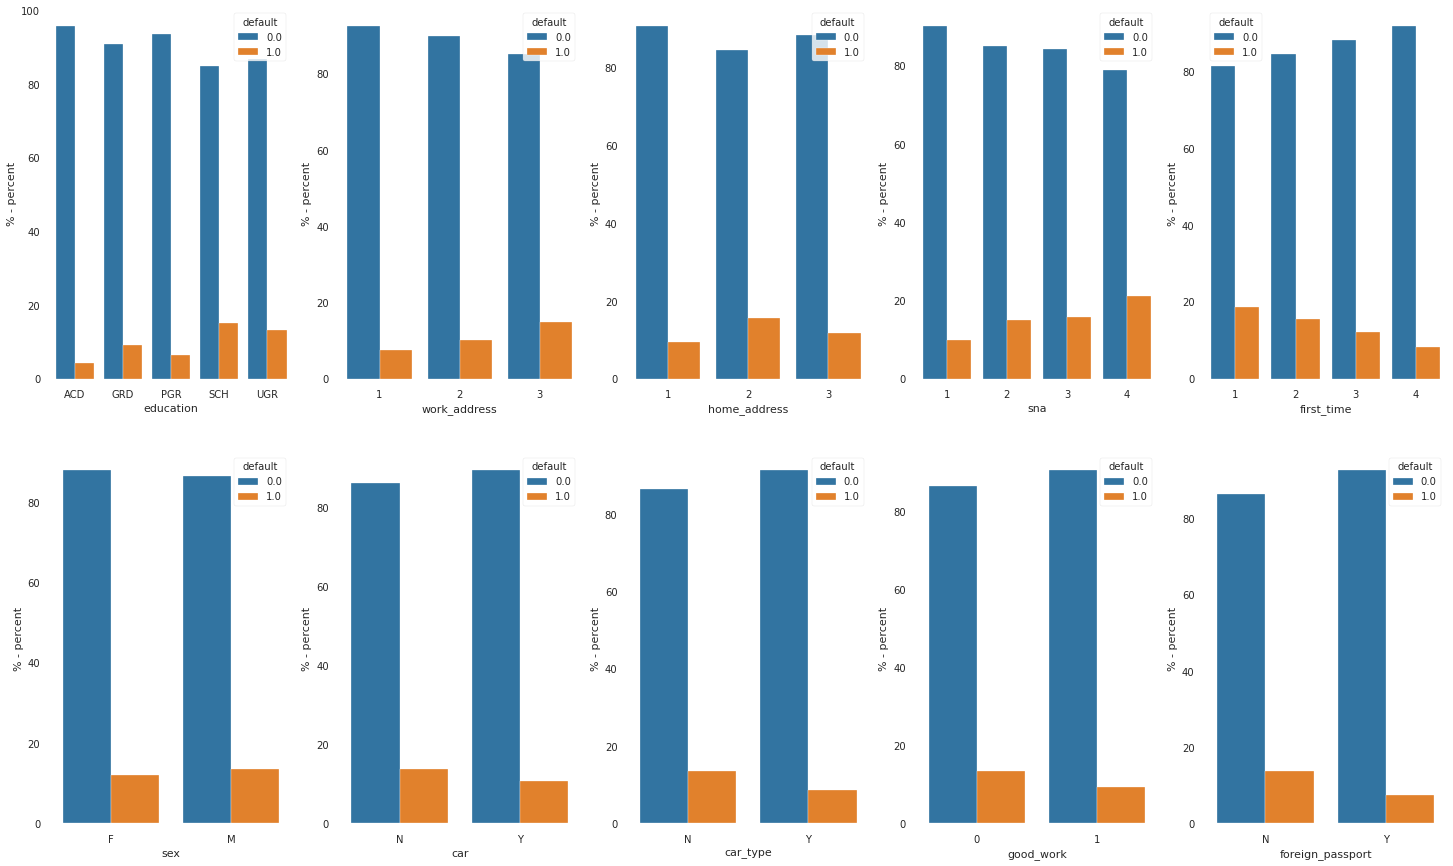

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(25, 15))
for i, col in enumerate(cat_cols + bin_cols):
    new_df = df.groupby(col)['default'].value_counts(normalize=True)
    new_df = new_df.mul(100).rename('% - percent').reset_index()
    sns.barplot(x=col, y='% - percent', hue='default', data=new_df, ax=axes.flat[i])

Интересно, что самый большой процент дефолтных клиентов:
- С уровнем образования SCH и UGR
- С рабочим адресом категории 3
- С домашним адресом категории 2
- Почти оданаковое процентное расспределение по sna - зеркально распределению по признаку first_time. Достаточно логично, ведь чем дольше история клиента в банке (ближе к 4) - тем лучше его отношения с банковским работником (ближе к 1)
- В категории 1 по признаку first_time, несмотря на то, что эта категория в датасете далеко не самая многочисленная

Данные наблюдения могут быть воспользованы для уменьшении размерности матрицы признаков через объединение некоторых категорий в одну.

- Относительно пола, процент дефолтных несколько выше у мужчин
- Больше дефолтных клиентов не имеют машину, либо имеют, но не иномарку. У них нету загранпаспорта и хуже работа.




Посмотрим на значимость категориальный и бинарных переменных методом ANOVA

<AxesSubplot:>

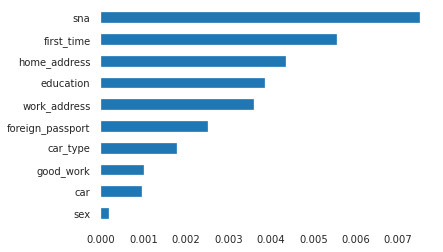

In [18]:
# значимость категориальных и бинарных переменных
train = df.query('train == 1').drop(['train'], axis=1)
# преобразуем бинарные признаки и категориальные в числовые
train = encode(train, option='wo/dummy')

imp_cat = pd.Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

# Корреляции

<AxesSubplot:>

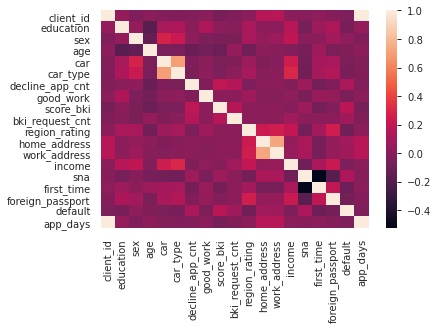

In [19]:
sns.heatmap(train.corr())

In [20]:
corr = train.corr().abs()
train_corr = corr.unstack()
train_corr = train_corr.sort_values(ascending=False).drop_duplicates()
train_corr[0:11]

client_id      client_id           1.000000
app_days       client_id           0.999582
home_address   work_address        0.728139
car            car_type            0.697939
sna            first_time          0.525206
car_type       income              0.302612
car            sex                 0.279488
region_rating  foreign_passport    0.255456
work_address   region_rating       0.253541
income         car                 0.248316
region_rating  home_address        0.233820
dtype: float64

Сильная корреляция между id клиента и app_days - скорей всего, id генерировались по возрастанию с первой записи в системе. Так же имеется существенная корреляция между home и work address (люди обычно выбирают жилье недалеко от работы либо наоборот). Как было замечено ранее, car и car_type дублируют информацию в некотором роде - поэтому переменные скоррелированы. Из матрицы корреляций, видно, что sna и first_time негативно скоррелированы, как было предположено ранее. Наличие иномарки не сильно, но коррелирует с уровнем дохода.


# Выбросы

In [21]:
# смотрим на выбросы числовых признаков
for col in num_cols:
    print(col)
    preproc.show_outliers(df, col)
    print("\n")

age
IQR range [3.0, 75.0] 
Min. value: 21 
Max. value: 72
Number of entries below the lower limit: 0, number of entries above the upper limit: 0


decline_app_cnt
IQR range [0.0, 0.0] 
Min. value: 0 
Max. value: 33
Number of entries below the lower limit: 0, number of entries above the upper limit: 18677


score_bki
IQR range [-3.299251946250001, -0.5290698762499992] 
Min. value: -3.62458632 
Max. value: 0.19977285
Number of entries below the lower limit: 82, number of entries above the upper limit: 436


income
IQR range [-22000.0, 90000.0] 
Min. value: 1000 
Max. value: 1000000
Number of entries below the lower limit: 0, number of entries above the upper limit: 7000


bki_request_cnt
IQR range [-4.5, 7.5] 
Min. value: 0 
Max. value: 53
Number of entries below the lower limit: 0, number of entries above the upper limit: 2636


region_rating
IQR range [35.0, 75.0] 
Min. value: 20 
Max. value: 80
Number of entries below the lower limit: 747, number of entries above the upper limit: 1717

Выбросов в признаке Age не найдено
Decline_app_cnt: в данной переменной 83% значений нулевые. Убирать все значения выше 0 - абсолютно лишено смысла. Посмотрим на процентное распределение уникальных значений

In [22]:
df['decline_app_cnt'].value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
15    0.000009
19    0.000009
20    0.000009
21    0.000009
22    0.000009
24    0.000009
30    0.000009
33    0.000009
Name: decline_app_cnt, dtype: float64

Значения выше 4 встречаются у меньше 0.5% данных. Предлагаю заменить все значения выше 4 - 4 и использовать как категориальный признак при построении модели 

In [23]:
df.loc[df['decline_app_cnt'] > 4, 'decline_app_cnt'] = 4

Похожая ситуация с переменной bki_request_cnt. Проделаем то же самое. 

In [24]:
df['bki_request_cnt'].value_counts(normalize=True)

0     0.262447
1     0.247803
2     0.185941
3     0.124106
4     0.076316
5     0.045030
6     0.022697
7     0.011730
8     0.006673
9     0.004167
10    0.003178
11    0.002524
12    0.001970
13    0.001371
14    0.000999
15    0.000735
16    0.000527
17    0.000300
18    0.000291
19    0.000272
21    0.000172
20    0.000127
24    0.000109
23    0.000109
22    0.000073
25    0.000045
27    0.000045
28    0.000045
26    0.000036
32    0.000036
29    0.000027
40    0.000018
33    0.000018
36    0.000009
34    0.000009
41    0.000009
45    0.000009
46    0.000009
47    0.000009
53    0.000009
Name: bki_request_cnt, dtype: float64

In [25]:
# определим порог значением 5. 
df.loc[df['bki_request_cnt'] > 5, 'bki_request_cnt'] = 5

В случае income, порог в 90000 так же не сильно реалистичен. Исходя из графиков распределения (выше), условная граница, после которой почти нету значений - 0.4 (на графике). Выберем верхнюю границу в 500к и заменим этим значением все, что выше.

In [26]:
df.loc[df['income'] > 500000, 'income'] = 500000

Score_bki: установим нижнюю границу согласно подсчетам. Для верхней границы используем значение 0 (таким образом модель показывает наилучший результат)

In [27]:
df.loc[df['score_bki'] < -3.299, 'score_bki'] = -3.299
df.loc[df['score_bki'] > 0, 'score_bki'] = 0

# Feauture Engineering

In [28]:
# создание нового признака - среднего значения дохода по рейтингу (используем только тренировочные данные)
mean_region_income = train.groupby('region_rating')['income'].mean().to_dict()
df['mean_region_income'] = df['region_rating'].map(mean_region_income)

# создание нового признака - среднего значения score_bki по рейтингу (используем только тренировочные данные)
mean_region_bki = train.groupby('region_rating')['score_bki'].mean().to_dict()
df['mean_region_bki'] = df['region_rating'].map(mean_region_bki)

In [29]:
# преобразуем бинарные переменные в числовые
df = encode(df,option="wo/dummy" )

In [30]:
# объеденим два признака в один, определяющий категорию: 0 - машины нету, 1 - есть, но не иномарка, 2 - есть, иномарка.
df['car_cat'] = df['car'] + df['car_type']
df.drop(['car', 'car_type'], axis=1, inplace=True)

# на основе таких числовые признаков, как age и income, создадим категориальные, разбив на категории-квантили
bin_quant(df,'age')
bin_quant(df,'income')

df.drop(['age', 'income'], axis=1, inplace=True)

# разобъем значения region_rating на две категории: выше и ниже 50
df['region_rating'] = df['region_rating'].apply(lambda x: 1 if x >= 50 else 0) 

# создадим полином третьей и 5той степени для score_bki, как для признака с наибольшей значимостью
df['score_bki_3'] = df['score_bki'].apply(lambda x: x ** 3)
#df['score_bki_5'] = df['score_bki'].apply(lambda x: x ** 5)

# создадим категориальный признак на основе bki_score (1 если выше среднего и 0 - если ниже)
df['bki_class'] = df['score_bki'].apply(lambda x: 1 if x >= train['score_bki'].mean() else 0)

# app_days сильно скоррелирован с client_id. переделаем его в категориальный признак, чтобы оставить некоторую информацию
df['app_days_class'] = df['app_days'].apply(lambda x: 1 if x >= train['app_days'].mean() else 0)
df.drop('app_days', axis=1, inplace=True)

Проведем декомпозицую адресов (work_address + home_address), объеденив два стандартизированных вектора в один с помощью PCA

In [31]:
#Декомпозиция адресов

# создадим Scaler
scaler = StandardScaler()
# здесь осторожно: нельзя вычислять среднее и отклонение по всей выборке, так как сольем данные по тестовой выборке, чего делать нельзя

# fit+transform применим к обучающей выборке, а к тестовой - только transform

data_addresses_train = df[df['train'] == 1][['work_address', 'home_address']].values
data_addresses_test = df[df['train'] == 0][['work_address', 'home_address']].values
scaled_data_train = scaler.fit_transform(data_addresses_train)
scaled_data_test = scaler.transform(data_addresses_test)
scaled_data = np.concatenate((scaled_data_train, scaled_data_test))

#У нас два вектора. Сократим до одного, оставив наиболее значимую информацию.
pca = PCA(n_components=1)
# в основе PCA лежит центрирование. похожая история, что и ранее. fit по тренировочной выборке, а transform на всей
pca.fit(scaled_data_train)
pca_data_train = pca.transform(scaled_data_train)
pca_data_test = pca.transform(scaled_data_test)
df['pca_address'] = np.concatenate((pca_data_train, pca_data_test))
df.drop(['home_address', 'work_address'], axis=1, inplace=True)


Несмотря на то, что pca и sna сильную отрицательную корреляцию, удаление хотя бы одного из них ухудшают качество модели. Попробуем создать новый признак на основе двух, воспользовавшись тем же приемом, что и с адресами. 

In [32]:
# Декомпозиция pca и sna

# разделяем тестовый и обучающий датасет для корректной стандартизации
data_train = df[df['train'] == 1][['sna', 'first_time']].values
data_test = df[df['train'] == 0][['sna', 'first_time']].values

scaled_data_train = scaler.fit_transform(data_train)
scaled_data_test = scaler.transform(data_test)
scaled_data = np.concatenate((scaled_data_train, scaled_data_test))

# сокращаем до одного вектора, центрируя выборки отдельно друг от друга
pca.fit(scaled_data_train)
pca_data_train = pca.transform(scaled_data_train)
pca_data_test = pca.transform(scaled_data_test)
df['pca_sna_first_time'] = np.concatenate((pca_data_train, pca_data_test))
df.drop(['sna', 'first_time'], axis=1, inplace=True)

In [33]:
# обновляем списки переменных
num_cols = ['score_bki', 'mean_region_income', 'mean_region_bki', 'score_bki_3'] 
cat_cols = ['education', 'app_days_class', 'bki_class', 'car_cat', 'pca_address', 'pca_sna_first_time', 'decline_app_cnt', 'bki_request_cnt', 'bin_age', 'bin_income'] 
bin_cols = ['foreign_passport', 'region_rating', 'good_work', 'sex'] 

Смотрим, насколько улучшились показатели после проведенных действий

In [34]:
df.columns

Index(['client_id', 'education', 'sex', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'foreign_passport',
       'default', 'train', 'mean_region_income', 'mean_region_bki', 'car_cat',
       'bin_age', 'bin_income', 'score_bki_3', 'bki_class', 'app_days_class',
       'pca_address', 'pca_sna_first_time'],
      dtype='object')

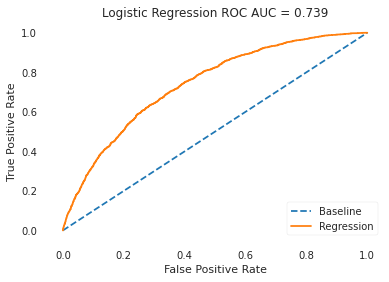

F1-score = 0.058
ROC AUC = 0.739


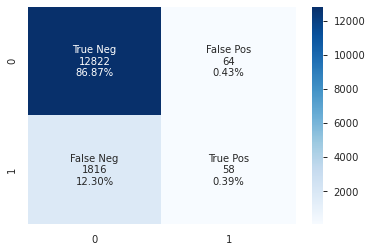

In [35]:
# создаем дамми переменные для категориальных признаков
df = pd.get_dummies(df, columns=cat_cols)

train = df.query('train == 1').drop(['train'], axis=1)
predict(train)

ROC AUC score теперь выглядит намного лучше: c помощью предобработки, а так же стандартизации данных удалось увеличить метрику с 0.60 до 0.739 и немного поднять F1. Модель теперь смогла правильно определить некоторое число дефолтных клиентов.

Посмотрим на значимость признаков в обновленном обработанном датасете и удалим те, у которых показатель равен 0

In [36]:
df_temp = df.query('train == 1').drop('train', axis=1)
num_columns = ['client_id', 'score_bki', 'mean_region_income', 'mean_region_bki']
# обновляем список бинарных и категориальных признаков, значимость которых будет оцениваться
bin_cat_columns = set(df_temp.columns) - set(num_columns) - set(['default'])

imp_cat = pd.Series(mutual_info_classif(df_temp[bin_cat_columns], df_temp['default'],
discrete_features=False), index=bin_cat_columns)

# создаем список из наименее значимых признаков для их удаления
cat_cols_to_drop = list(imp_cat[imp_cat==0].index)
df.drop(cat_cols_to_drop, axis=1, inplace=True)

In [37]:
# то же самое для численных переменных - практика показала, что их удалять не стоит
#corr = df.corr().abs()
#train_corr = corr.unstack()
#train_corr = train_corr.sort_values(ascending=False).drop_duplicates()
#corr_to_drop = train_corr[1:][train_corr>0.7].reset_index()['level_1'].to_list()
#df.drop(corr_to_drop, axis=1,inplace=True)

# Modeling

Посмотрим, как справятся другие модели на стандартных настройках

In [38]:
# обновим тренировочную выборку
train = df.query('train == 1').drop(['train'], axis=1)

logreg = LogisticRegression(max_iter=1000)
rforest = RandomForestClassifier(n_estimators=1000)
GB = GradientBoostingClassifier(n_estimators=1000)
ad = AdaBoostClassifier(n_estimators=1000)

models = [logreg, rforest, GB, ad]

for model in models:
    predict_model(train, model)

LogisticRegression(max_iter=1000) 
F1_score: 0.058, ROC AUC score: 0.738

RandomForestClassifier(n_estimators=1000) 
F1_score: 0.035, ROC AUC score: 0.709

GradientBoostingClassifier(n_estimators=1000) 
F1_score: 0.080, ROC AUC score: 0.730

AdaBoostClassifier(n_estimators=1000) 
F1_score: 0.068, ROC AUC score: 0.734



Лучший показатель ROC AUC score у логистической регрессии, но ее точность оставляет желать лучшего.

Достаточно обещающие результаты у GradientBoostingClassifier в контексте F1 score. ROC AUC при этом несколько хуже. 

AdaBoostClassifier - некоторый trade-off между F1 score и ROC AUC. 

Продолжим работать с логистической регрессией дальше, оставив другие модели на потом

## **Hyperparameters tuning**

попробуем поискать лучшую комбинацию параметров для Logistic Regression с помощью GridSearch

In [39]:
X = train.drop('default', axis=1)
y = train['default']

# определяем параметры
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['none', 'l1', 'l2']
c_values = [100, 10, 1.0, 0.1]

model = LogisticRegression()
 
# определяем grid search и запускаем поиск лучшей комбинации
grid = dict(solver=solvers, penalty=penalty, C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X, y)

# выводим результаты
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algo

Best: 0.735118 using {'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


## **Final result**

In [40]:
# разделяем выборки обратно на тренировочную и тестовую
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)


X_train = train.drop('default', axis=1)
y_train = train['default']
X_test = test.drop('default', axis=1)

# стандартизируем отдельно
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# обучаем модель, используя подобранные параметры 
m = LogisticRegression(C=100, penalty='l2', solver='newton-cg')
m.fit(X_train_st, y_train)
y_pred = m.predict(X_test_st)
y_pred_proba = m.predict_proba(X_test_st)
y_pred_proba = y_pred_proba[:,1]


In [41]:
results_df = pd.DataFrame(data={'client_id': test['client_id'], 'default': y_pred_proba})
results_df.to_csv('submission.csv', index=False)

In [42]:
results_df

client_id   default
73799       74835  0.032109
73800       17527  0.375217
73801       75683  0.057778
73802       26883  0.083089
73803       28862  0.022619
...           ...       ...
110143      83775  0.339739
110144     106254  0.016238
110145      81852  0.297552
110146       1971  0.254726
110147      69044  0.236397

[36349 rows x 2 columns]

## ** Miscellaneous

* возгалались большие надежды на oversampling. При этом в любом из случаев (как методом SMOTE, так и Random) модель показывала худший результат, поэтому пришлось вовсе отказаться 
* пыталась найти лучший параметр weight_class для логистической регрессии через GridSearch. Так и не удалось заставить код работать из-за convergence error, настройка max_iter при этом не помогла. Подбирала вручную разные рандомные значения, при этом результат ухудшался